In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer/Churn_Modelling.csv


1.Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

2.Import data

In [3]:
df = pd.read_csv('/kaggle/input/customer/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
print(df.columns)

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [5]:
# Drop Columns
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [6]:
#Check Missing Value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


3.Exploration data

In [7]:
print(df.describe())

        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

         HasCrCard  IsActiveMember  EstimatedSalary        Exited  
count  10000.00000    10000.000000     10000.000000  10000.000000  
mean       0.70550        0.515100    100090.239881      0.203700  
std        0.45584        0.499797     57510.492818      0.402769 

3.1 Distribution visualization

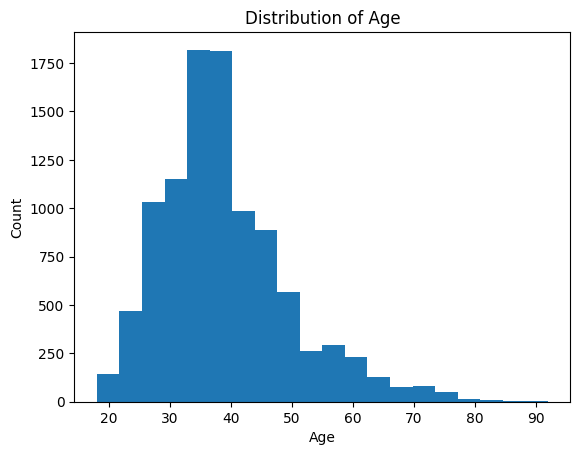

In [8]:
# Histogram From variabel Age
plt.hist(df['Age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show()

From the plot results, it is found that the highest distribution of values is concentrated around the age range of 35-40 years.

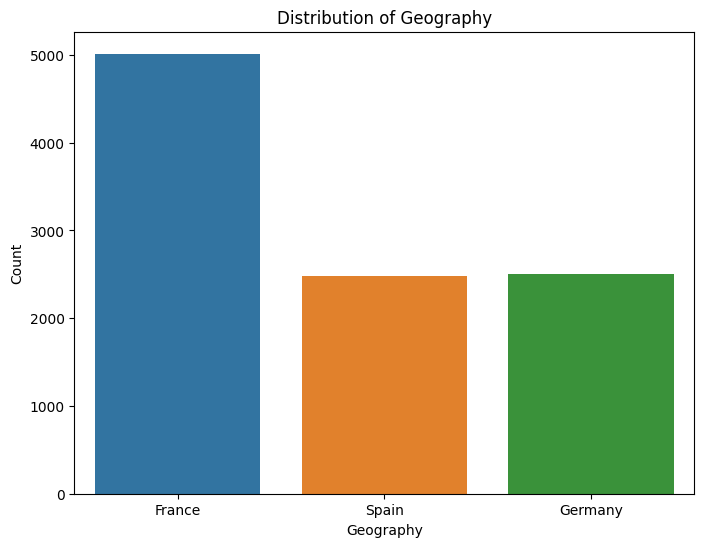

In [9]:
# Plot Distribution variabel Geography
plt.figure(figsize=(8, 6))
sns.countplot(x='Geography', data=df)
plt.xlabel('Geography')
plt.ylabel('Count')
plt.title('Distribution of Geography')
plt.show()

From the plot results, it is found that the highest distribution of values in the "Geography" column is in the country of France.

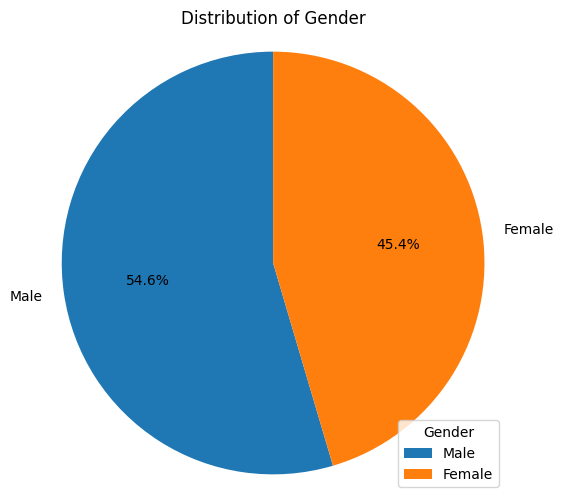

In [10]:
#Distribution of Gender
gender_counts = df['Gender'].value_counts()

labels = gender_counts.index
sizes = gender_counts.values

# Pie plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Gender')
plt.axis('equal')
plt.legend(title='Gender')

plt.show()

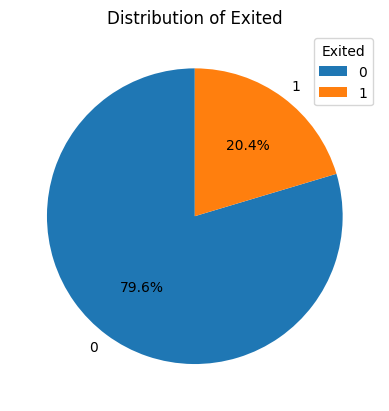

In [11]:
# Calculate the count of each category in the "Exited" feature
exited_counts = df['Exited'].value_counts()

labels = exited_counts.index
plt.pie(exited_counts, labels=labels, autopct='%1.1f%%', startangle=90)

plt.title("Distribution of Exited")
plt.legend(title='Exited')
plt.show()

In [12]:
gender_churn = df.groupby('Age')['Exited'].mean()
print(gender_churn)

Age
18    0.090909
19    0.037037
20    0.050000
21    0.056604
22    0.142857
        ...   
83    0.000000
84    0.500000
85    0.000000
88    0.000000
92    0.000000
Name: Exited, Length: 70, dtype: float64


3.3 Feature importance with random forest

In [13]:
# Build LabelEncoder
label_encoder = LabelEncoder()

# Encoding the "Geography" and "Gender" columns
df['Geography_encoded'] = label_encoder.fit_transform(df['Geography'])
df['Gender_encoded'] = label_encoder.fit_transform(df['Gender'])

# Separating feature and target variables
X = df.drop(['Exited', 'Geography', 'Gender'], axis=1)
y = df['Exited']

# Build Random Forest model
model = RandomForestClassifier()
model.fit(X, y)

# Show feature importance
importance = model.feature_importances_
feature_names = X.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance)

             Feature  Importance
1                Age    0.238914
7    EstimatedSalary    0.149055
0        CreditScore    0.145546
3            Balance    0.140569
4      NumOfProducts    0.131403
2             Tenure    0.080917
6     IsActiveMember    0.040104
8  Geography_encoded    0.036276
5          HasCrCard    0.019416
9     Gender_encoded    0.017801


4.Splitting data

In [14]:
# Perform label encoding on categorical columns
label_encoder = LabelEncoder()
df['Geography'] = label_encoder.fit_transform(df['Geography'])
df['Gender'] = label_encoder.fit_transform(df['Gender'])

# Split the dataframe into features (X) and target (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

# Perform train-test split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Train the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_train, y_train)
print("Accuracy:", accuracy)
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9631428571428572
Accuracy: 0.8593333333333333


After performing 5-fold cross-validation, the obtained results show the accuracy scores for each fold in the form of an array [0.857, 0.8575, 0.8585, 0.857, 0.8495]. The average accuracy across all folds is 0.8559.

4.1.Cross validation

In [16]:
from sklearn.model_selection import cross_val_score

# Build XGBoost model
model = xgb.XGBClassifier()

# Running cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print cross-validation Score
print("Cross-Validation Scores:", scores)
print("Average Accuracy:", np.mean(scores))

Cross-Validation Scores: [0.8535 0.86   0.854  0.858  0.848 ]
Average Accuracy: 0.8547


After performing 5-fold cross-validation, the obtained results show the accuracy scores for each fold in the form of an array [0.857, 0.8575, 0.8585, 0.857, 0.8495]. The average accuracy across all folds is 0.8559.

4.2 Hyper Parameter Tunning¶
4.2.1 Grid Search CV

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

In [19]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [20]:
# Print Best Parameter
print("Best Parameters: ", grid_search.best_params_)

# Print Best Cross Validation Score
print("Best Cross-Validation Score: ", grid_search.best_score_)

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Best Cross-Validation Score:  0.8594285714285714


In [21]:
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [22]:
print ('Training')
# Evaluate best model testing
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_train, y_train)
print("Accuracy on Test Data: ", accuracy)
print(classification_report(y_train, y_train_pred))

print ('')

print ('Testing')
# Evaluate best model testing
accuracy = best_model.score(X_test, y_test)
print("Accuracy on Test Data: ", accuracy)
print(classification_report(y_test, y_test_pred))

Training
Accuracy on Test Data:  0.8778571428571429
              precision    recall  f1-score   support

           0       0.88      0.97      0.93      5547
           1       0.83      0.52      0.64      1453

    accuracy                           0.88      7000
   macro avg       0.86      0.74      0.78      7000
weighted avg       0.87      0.88      0.87      7000


Testing
Accuracy on Test Data:  0.8713333333333333
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.78      0.47      0.59       584

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.76      3000
weighted avg       0.86      0.87      0.86      3000



In Hyperparameter tuning using Grid Search CV, improvements in accuracy were achieved for both the training and testing data. The accuracy on the training data increased to 0.8765714285714286, while the accuracy on the testing data reached 0.8733333333333333.

These results indicate that the enhanced model, utilizing the best hyperparameters obtained from GridSearchCV, outperforms the default model.

4.2.2 Randomized Search CV

In [23]:
from sklearn.model_selection import RandomizedSearchCV

In [24]:
param_grid = {
    'max_depth': np.arange(3, 6),
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': np.arange(100, 301, 100)
}

In [25]:
# Buat objek RandomizedSearchCV
rs = RandomizedSearchCV(model, param_distributions=param_grid, cv=5, scoring='accuracy', n_iter=10)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': array([3, 4, 5]),
                                        'n_estimators': array([100, 200, 300])},
                   scoring='accuracy')

In [26]:
# Print Best Parameter
print("Best Parameters: ", rs.best_params_)
# Print Best Cross Validation Score
print("Best Cross-Validation Score: ", rs.best_score_)

Best Parameters:  {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}
Best Cross-Validation Score:  0.8562857142857142


In [27]:
print ('Training')
# Evaluate best model testing
best_model = rs.best_estimator_
accuracy = best_model.score(X_train, y_train)
print("Accuracy on Test Data: ", accuracy)
print(classification_report(y_train, y_train_pred))

print ('')

print ('Testing')
# Evaluate best model testing
accuracy = best_model.score(X_test, y_test)
print("Accuracy on Test Data: ", accuracy)
print(classification_report(y_test, y_test_pred))

Training
Accuracy on Test Data:  0.8807142857142857
              precision    recall  f1-score   support

           0       0.88      0.97      0.93      5547
           1       0.83      0.52      0.64      1453

    accuracy                           0.88      7000
   macro avg       0.86      0.74      0.78      7000
weighted avg       0.87      0.88      0.87      7000


Testing
Accuracy on Test Data:  0.8713333333333333
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.78      0.47      0.59       584

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.76      3000
weighted avg       0.86      0.87      0.86      3000

